The purpose of this notebook is to select a reasonable collection of subjects for a dimensional neuroimaging study of the onset of BP symptoms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
table_path_fstring = "/home/ebrahim/data/abcd/Package_1200530/{}.txt"
table_path_fstring2 = "/home/ebrahim/data/abcd/Package_1200951/{}.txt"
dict_path_fstring = "/home/ebrahim/data/abcd/abcd-4.0-data-dictionaries/{}.csv"

def read_abcd_table(table_name, include_data_dict = True, use_alternative_package = False):
    if use_alternative_package:
        table_path = table_path_fstring2.format(table_name)
    else:
        table_path = table_path_fstring.format(table_name)
    
    df = pd.read_csv(table_path, sep='\t', header=0, skiprows=[1], low_memory=False)
    
    if include_data_dict:
        dict_path = dict_path_fstring.format(table_name)
        data_dictionary = pd.read_csv(dict_path, index_col='ElementName')
        return df, data_dictionary
    else:
        return df

In [333]:
# Load data

# Demographic data
demo, demo_dd = read_abcd_table("pdem02")
ldemo, ldemo_dd = read_abcd_table("abcd_lpds01") # longitudinal version

# raw survey data for bipolar
bp, bp_dd = read_abcd_table("bipolar_disorders_p01", use_alternative_package=True) # parent survey
bp_youth, bp_youth_dd = read_abcd_table("bipolar_disorders01", use_alternative_package=True) # youth survey

# mental health data
mh, mh_dd = read_abcd_table("abcd_ksad01")

# DMRI imaging data
dmri = read_abcd_table("fmriresults01", include_data_dict=False)

In [387]:
# Fix row duplication issue

demo = demo.groupby('subjectkey', as_index=False).apply(lambda s : s.iloc[0])
mh = mh.groupby(['subjectkey', 'interview_age'], as_index=False).apply(lambda s: s.iloc[0])
dmri = dmri.groupby(['subjectkey', 'interview_age', 'fmriresults01_id'], as_index=False).apply(lambda x : x.iloc[0])

# ldemo also has a row duplication problem, but there are two subjects that have
# their 2 and 3 year follow up occuring at the same interview_age. drop these. then fix the row duplication
ldemo = ldemo[(ldemo.subjectkey!='NDAR_INV7YM285FW') & (ldemo.subjectkey!='NDAR_INV99J6PWJX')]
ldemo = ldemo.groupby(['subjectkey', 'interview_age'], as_index=False).apply(lambda s: s.iloc[0])

# Subject Selection
Our largest number of subjects to select is the number who completed at least one survey from the 3 time points:

In [74]:
bp.subjectkey.nunique()

11488

Or we could only keep the subjects who did the survey at all 3 time points:

In [92]:
sum(bp.groupby('subjectkey').apply(lambda x : len(x)) == 3)

10186

We can instead focus on subjects who had any BP symptom as indicated by KSADS diagnistics, with a sampling of the same number of healthy controls.

In [93]:
# Collect list of KSADS diagnostic column names related to BP
bp_elementnames = mh_dd[mh_dd.ElementDescription.str.contains("Bipolar", case=False)].index
for en in bp_elementnames:
    print(mh_dd.loc[en].ElementDescription)

Diagnosis - Bipolar II Disorder most recent past hypomanic ξF31.81
Diagnosis - Bipolar II Disorder currently hypomanic ξF31.81
Diagnosis - Bipolar II Disorder currently depressed F31.81
Diagnosis - Bipolar I Disorder current episode depressed F31.3x
Diagnosis - Bipolar I Disorder currently hypomanic  F31.0
Diagnosis - Bipolar I Disorder current episode manic (F31.1x)
Diagnosis - Bipolar I Disorder most recent past episode manic (F31.1x)
Diagnosis - Bipolar I Disorder most recent past episode depressed (F31.1.3x)
Diagnosis - Unspecified Bipolar and Related Disorder PAST (F31.9)
Diagnosis - Unspecified Bipolar and Related Disorder current ξ(F31.9)
Symptom - Hospitalized due to Bipolar Disorder Present
Symptom - Hospitalized due to Bipolar Disorder Past
Symptom - Impairment in functioning due to bipolar Past
Symptom - Impairment in functioning due to bipolar Present
Symptom - Preliminary substance rule out bipolar present
Symptom - Preliminary substance rule out bipolar past
Symptom - Psy

In [118]:
mh[bp_elementnames].ksads_2_837_p.value_counts()

0.0      21744
555.0    11225
1.0        207
888.0       11
Name: ksads_2_837_p, dtype: int64

In [125]:
mh['some_bp_thing'] = mh[bp_elementnames].apply(lambda x : (x==1).any(), axis=1)

In [133]:
mh.groupby('subjectkey').some_bp_thing.agg(func='any').value_counts()

False    8687
True     3189
Name: some_bp_thing, dtype: int64

That would be 3189 subjects; maybe we can restrict to the more clear diagnositic columns only.

In [139]:
mh['some_bp_thing2'] = mh[bp_elementnames[:10]].apply(lambda x : (x==1).any(), axis=1)
mh['some_bp_thing3'] = mh[bp_elementnames[:8]].apply(lambda x : (x==1).any(), axis=1)

In [144]:
mh.groupby('subjectkey').some_bp_thing2.agg(func='any').value_counts()

False    10817
True      1059
Name: some_bp_thing2, dtype: int64

In [145]:
mh.groupby('subjectkey').some_bp_thing3.agg(func='any').value_counts()

False    11308
True       568
Name: some_bp_thing3, dtype: int64

That last one seems like a good number to take: 568 subjects.
So that would be those who have a positive in at least one of the following KSADS diagnostics for at least one interview age:

In [146]:
for en in bp_elementnames[:8]:
    print(mh_dd.loc[en].ElementDescription)

Diagnosis - Bipolar II Disorder most recent past hypomanic ξF31.81
Diagnosis - Bipolar II Disorder currently hypomanic ξF31.81
Diagnosis - Bipolar II Disorder currently depressed F31.81
Diagnosis - Bipolar I Disorder current episode depressed F31.3x
Diagnosis - Bipolar I Disorder currently hypomanic  F31.0
Diagnosis - Bipolar I Disorder current episode manic (F31.1x)
Diagnosis - Bipolar I Disorder most recent past episode manic (F31.1x)
Diagnosis - Bipolar I Disorder most recent past episode depressed (F31.1.3x)


In [311]:
# indicates whether a given *subject* had at least one interview that contained a positive diagnostic
subject_positive_bp = mh.groupby('subjectkey').some_bp_thing3.agg(func='any')

# indicates whether a given subject did all three of their interviews
subject_interview_complete = mh.groupby('subjectkey').apply(lambda x : len(x)) == 3

# indicates whether a given subject did all two of their scans
subject_scans_complete = dmri.groupby(['subjectkey']).apply(lambda x : x.interview_age.nunique()) == 2

# Concatenate into a dataframe
subject_inclusion_criteria = pd.concat(
    {'positive_bp':subject_positive_bp,
     'interview_complete':subject_interview_complete,
     'scans_complete':subject_scans_complete
    }, axis=1)

subject_inclusion_criteria = subject_inclusion_criteria.replace(np.nan, False)

If we want to include the subjects that satisfy all three of these criteria, then here's how many subjects we get:

In [320]:
subject_inclusion_criteria.all(axis=1).sum()

290

If we then want to include the same number of healthy controls, then we can take a random sample that is stratified based on the demographics of these 290. (Or should it be stratified based on the demographics of the full abcd study cohort?)

# COVID-19 Lockdown Effects
Let's now look at the interview dates for those included subjects.

In [ ]:
included_subjects = subject_inclusion_criteria[subject_inclusion_criteria.all(axis=1)].index

In [452]:
time_index_mapping = {
    'baselineYear1Arm1' : 0,
    '2YearFollowUpYArm1' : 1
}
dmri['time_index'] = dmri.derived_files.apply(lambda x : time_index_mapping[x.split('/')[-1].split('_')[1]])

In [519]:
dmri.interview_date = pd.to_datetime(dmri.interview_date)

def year_and_month_to_month_offset(year, month, day):
    return (year-2018)*12 + month + day/30.5

dmri_second_scan_included_subjects = dmri[dmri.subjectkey.isin(included_subjects) & dmri.time_index==1]
dmri_second_scan_included_unique_subjects = dmri_second_scan_included_subjects.groupby('subjectkey').apply(lambda x : x.iloc[0])
month_offsets = dmri_second_scan_included_unique_subjects.interview_date.apply(lambda x : year_and_month_to_month_offset(x.year,x.month, x.day))
lockdown_month_offset = year_and_month_to_month_offset(2020,3,20)

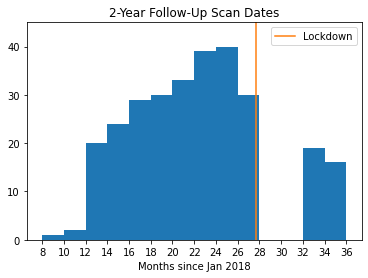

In [530]:
bins = range(8,38,2)
plt.hist(month_offsets, bins=bins)
plt.plot([lockdown_month_offset,lockdown_month_offset],[0,100], label="Lockdown")
plt.xticks(ticks = bins)
plt.ylim(0,45)
plt.yticks(ticks=range(0,50,10))
plt.xlabel("Months since Jan 2018")
plt.title("2-Year Follow-Up Scan Dates")
plt.legend()
plt.show()

In [529]:
(month_offsets > lockdown_month_offset).value_counts()

False    248
True      42
Name: interview_date, dtype: int64

This is great. Of the 290 selected BP subjects, 42 of them had their second scan after lockdown measures, and 248 of them before. That means we can _ignore_ lockdown effects by restricting to those 248 and it's not a serious loss at all. And we can also _observe_ lockdown effects if we want to, because 42 is a decent number of positive post-lockdown cases to have.